In [149]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [150]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [152]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [153]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


In [154]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Load data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

# Simple survival analysis
women = train_data.loc[train_data.Sex == 'female', "Survived"]
men = train_data.loc[train_data.Sex == 'male', "Survived"]

print("% of women who survived:", women.mean())
print("% of men who survived:", men.mean())

# Target
y = train_data["Survived"]

# Features
features = ["Pclass", "Sex", "SibSp", "Parch"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

# Align train and test columns
X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

# Model
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=1
)

model.fit(X, y)

# Predictions
predictions = model.predict(X_test)

# Submission
output = pd.DataFrame({
    "PassengerId": test_data.PassengerId,
    "Survived": predictions
})

output.to_csv("submission.csv", index=False)

print("Your submission was successfully saved!")


% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924
Your submission was successfully saved!


In [155]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier


In [156]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")


In [157]:
# Family features
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Title extraction
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(
        ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],
        'Rare'
    )
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')


In [158]:
for df in [train, test]:
    df['Age'] = df['Age'].fillna(df.groupby('Title')['Age'].transform('median'))
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode().iloc[0])


In [159]:
for df in [train, test]:
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    df['Title'] = df['Title'].map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Rare':4})


In [160]:
features = [
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'FamilySize',
    'IsAlone',
    'Embarked',
    'Title'
]

X = train[features]
y = train['Survived']
X_test = test[features]


In [161]:
model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("CV Accuracy:", cv_scores.mean())


CV Accuracy: 0.8395078777226791


In [162]:
model.fit(X, y)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [163]:
predictions = model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)
print("Submission file created!")


Submission file created!


In [164]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier


In [165]:
numeric_features = [
    'Age', 'Fare', 'FamilySize'
]

categorical_features = [
    'Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone'
]


In [166]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [167]:
model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)


In [168]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])


In [169]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(clf, X, y, cv=cv)

print(classification_report(y, y_pred))
print(confusion_matrix(y, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.89      0.87       549
           1       0.81      0.75      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.83      0.84      0.83       891

[[489  60]
 [ 87 255]]


In [170]:
error_df = train.copy()
error_df['pred'] = y_pred

error_df['error'] = (error_df['pred'] != error_df['Survived'])

error_df.groupby('Sex')['error'].mean()
error_df.groupby('Pclass')['error'].mean()


Pclass
1    0.245370
2    0.081522
3    0.160896
Name: error, dtype: float64

In [171]:
clf.fit(X, y)
predictions = clf.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions
})

submission.to_csv("submission.csv", index=False)


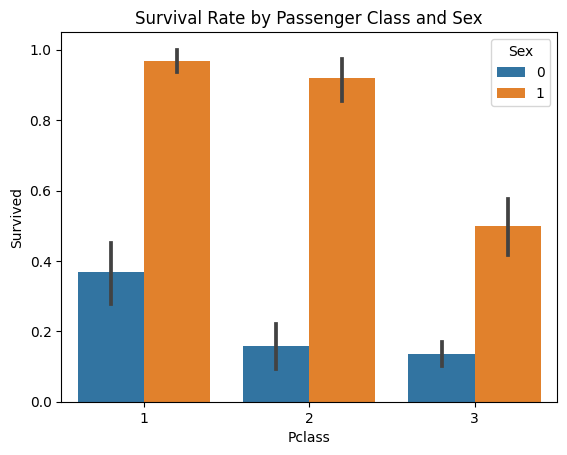

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)
plt.title("Survival Rate by Passenger Class and Sex")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


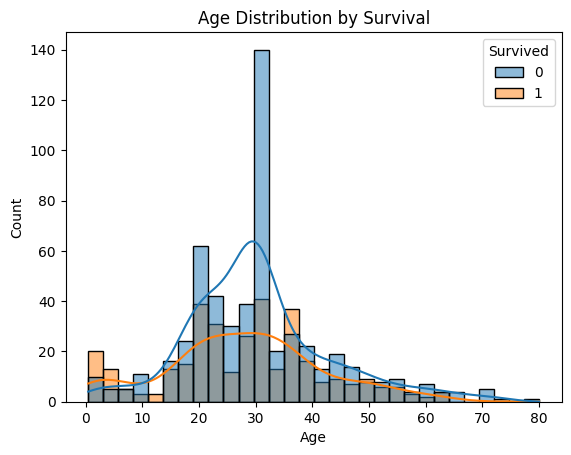

In [173]:
sns.histplot(data=train, x='Age', hue='Survived', bins=30, kde=True)
plt.title("Age Distribution by Survival")
plt.show()


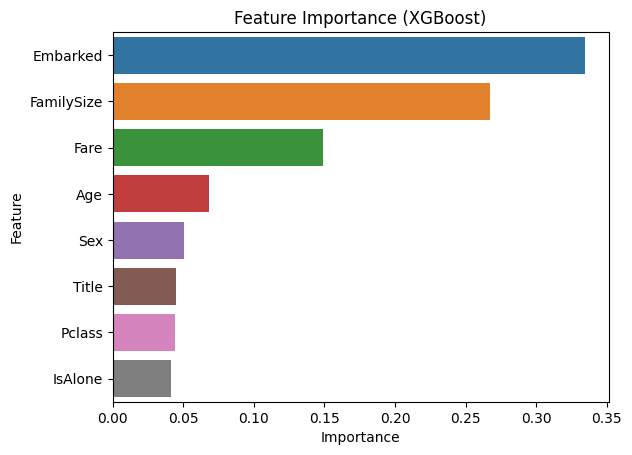

In [174]:
import pandas as pd

importance = model.feature_importances_
feature_names = X.columns

imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title("Feature Importance (XGBoost)")
plt.show()


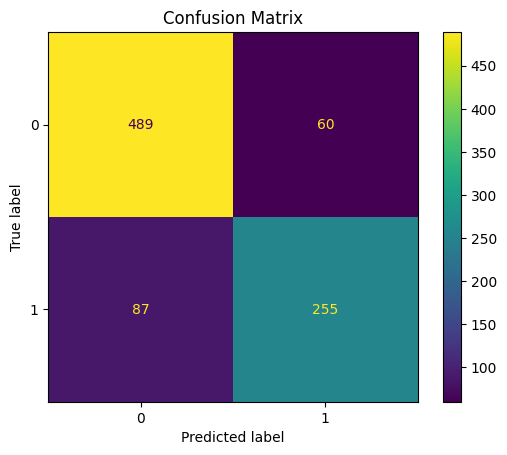

In [175]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y, y_pred)
plt.title("Confusion Matrix")
plt.show()
